In [18]:
!pip install hdf5storage
!git clone https://github.com/adityajn105/brain-tumor-segmentation-unet
!bash download_data.sh
!python mat_to_numpy.py brain_tumor_dataset/

fatal: destination path 'brain-tumor-segmentation-unet' already exists and is not an empty directory.
mkdir: brain_tumor_dataset: File exists
replace cvind.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
[1360/3064] images loaded: 44.4 %

[1640/3064] images loaded: 53.5 %

In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

integer_to_class = {'1': 'meningioma (1)', '2': 'glioma (2)', '3': 'pituitary tumor (3)'}

##Load images, labels, masks
labels = np.load('brain_tumor_dataset/labels.npy')
images = np.clip( (np.load('brain_tumor_dataset/images.npy')/12728),0,1)
masks = np.load('brain_tumor_dataset/masks.npy')*1
print(labels.shape)
print(images.shape)
print(masks.shape)

(3064,)
(3064, 512, 512)
(3064, 512, 512)


In [43]:
from skimage.transform import resize
img_size_ori = 512
img_size_target = 128

images = np.expand_dims(images,axis=-1)
masks = np.expand_dims(masks,axis=-1)

def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True,)
    
def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
  
images = np.array([ downsample(image) for image in images ])
masks = (np.array([ downsample(mask) for mask in masks ])>0)*1

print(images.shape)
print(masks.shape)  

(3064, 128, 128, 1)
(3064, 128, 128, 1)


[ 708 1426  930]


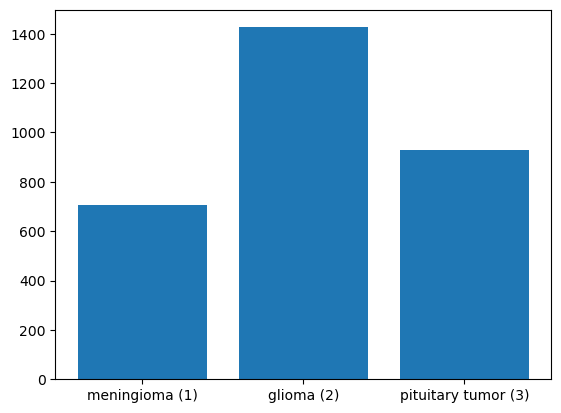

In [44]:
classes, counts = np.unique(labels,return_counts=True)
plt.bar(classes,counts,tick_label=list(integer_to_class.values()))
print(counts)

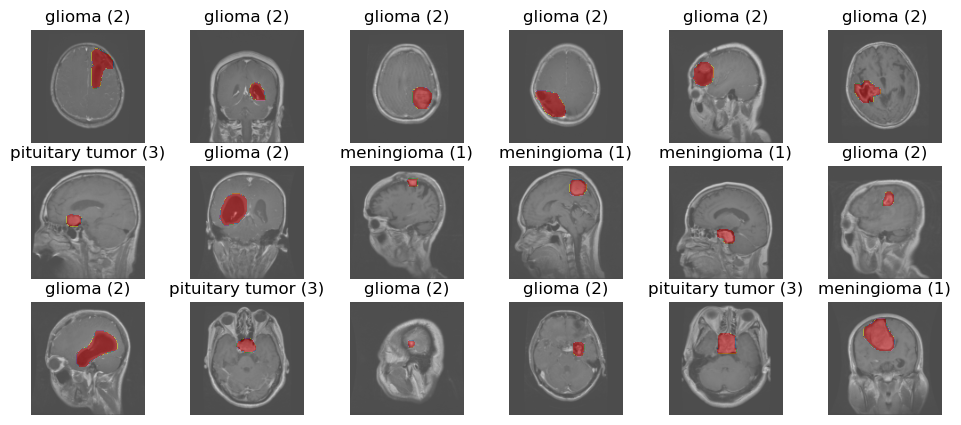

In [45]:
plt.figure(figsize=(12, 5))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow( np.squeeze(images[idx],axis=-1), cmap='gray')
    plt.imshow( np.squeeze(np.ones_like(masks[idx])-masks[idx],axis=-1), alpha=0.5, cmap='Set1')
    plt.title(integer_to_class[str(labels[idx])])
    plt.axis('off')

### Train Image and its mask which is to be predicted

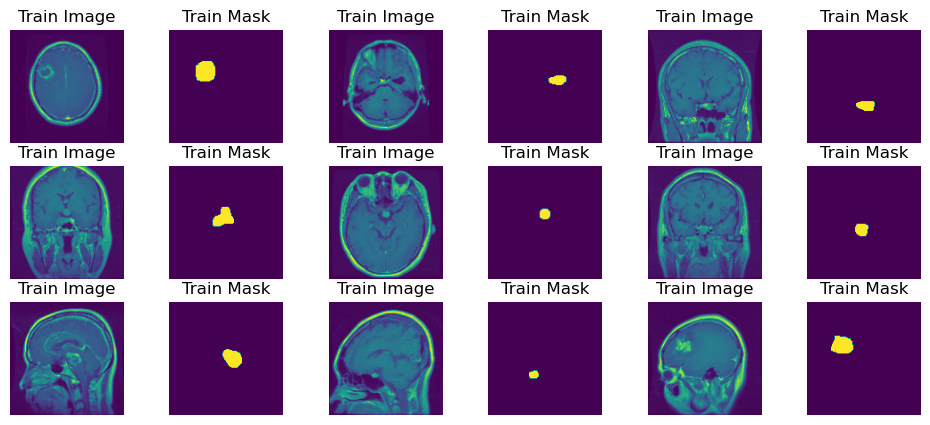

In [46]:
plt.figure(figsize=(12, 5))
i=1
for idx in np.random.randint( images.shape[0], size=9):
  plt.subplot(3,6,i);i+=1
  plt.imshow( np.squeeze(images[idx],axis=-1))
  plt.title("Train Image")
  plt.axis('off')
  plt.subplot(3,6,i);i+=1
  plt.imshow( np.squeeze(masks[idx],axis=-1)) 
  plt.title("Train Mask")
  plt.axis('off')

In [47]:
from sklearn.model_selection import train_test_split
import gc
X,X_v,Y,Y_v = train_test_split( images,masks,test_size=0.2,stratify=labels)
del images
del masks
del labels
gc.collect()
X.shape,X_v.shape

((2451, 128, 128, 1), (613, 128, 128, 1))

### Augmentation

In [48]:
X = np.append( X, [ np.fliplr(x) for x in X], axis=0 )
Y = np.append( Y, [ np.fliplr(y) for y in Y], axis=0 )
X.shape,Y.shape

((4902, 128, 128, 1), (4902, 128, 128, 1))

In [49]:
#from keras.preprocessing.image import ImageDataGenerator
from keras.src.legacy.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(brightness_range=(0.9,1.1),
                                   zoom_range=[.9,1.1],
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator()

### Defining Dice Loss
Dice = 2|A∩B|/|A|+|B|

In [59]:
from keras.losses import binary_crossentropy
#from keras import backend as K
from tensorflow.keras import backend as K
import tensorflow as tf
from keras.layers import Flatten
#editing the flatten function

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = Flatten(y_true)
    y_pred_f = Flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

### bce_dice_loss = binary_crossentropy_loss + dice_loss
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [51]:
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, Input, BatchNormalization
from keras import optimizers
from keras.models import Model

IMG_DIM = (128,128,1)

def conv2d_block( input_tensor, n_filters, kernel_size = (3,3), name="contraction"):
  "Add 2 conv layer"
  x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
             padding='same',activation="relu", name=name+'_1')(input_tensor)
  
  x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
             padding='same',activation="relu",name=name+'_2')(x)
  return x
  

inp = Input( shape=IMG_DIM )

d1 = conv2d_block( inp, 64, name="contraction_1")
p1 = MaxPooling2D( pool_size=(2,2), strides=(2,2))(d1)
p1 = BatchNormalization(momentum=0.8)(p1)
p1 = Dropout(0.1)(p1)

d2 = conv2d_block( p1, 128, name="contraction_2_1" )
p2 = MaxPooling2D(pool_size=(2,2), strides=(2,2) )(d2)
p2 = BatchNormalization(momentum=0.8)(p2)
p2 = Dropout(0.1)(p2)

d3 = conv2d_block( p2, 256, name="contraction_3_1")
p3 = MaxPooling2D(pool_size=(2,2), strides=(2,2) )(d3)
p3 = BatchNormalization(momentum=0.8)(p3)
p3 = Dropout(0.1)(p3)

d4 = conv2d_block(p3,512, name="contraction_4_1")
p4 = MaxPooling2D(pool_size=(2,2), strides=(2,2) )(d4)
p4 = BatchNormalization(momentum=0.8)(p4)
p4 = Dropout(0.1)(p4)

d5 = conv2d_block(p4,512, name="contraction_5_1")

u1 = Conv2DTranspose(512, (3, 3), strides = (2, 2), padding = 'same')(d5)
u1 = concatenate([u1,d4])
u1 = Dropout(0.1)(u1)
c1 = conv2d_block(u1, 512, name="expansion_1")

u2 = Conv2DTranspose(256, (3, 3), strides = (2, 2), padding = 'same')(c1)
u2 = concatenate([u2,d3])
u2 = Dropout(0.1)(u2)
c2 = conv2d_block(u2, 256, name="expansion_2")

u3 = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(c2)
u3 = concatenate([u3,d2])
u3 = Dropout(0.1)(u3)
c3 = conv2d_block(u3, 128, name="expansion_3")

u4 = Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = 'same')(c3)
u4 = concatenate([u4,d1])
u4 = Dropout(0.1)(u4)
c4 = conv2d_block(u4,64, name="expansion_4")

out = Conv2D(1, (1,1), name="output", activation='sigmoid')(c4)

unet = Model( inp, out )
unet.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_1_1     │ (None, 128, 128,  │        640 │ input_layer_1[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_1_2     │ (None, 128, 128,  │     36,928 │ contraction_1_1[… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ contraction_1_2[… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ max_pooling2d_4[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_2_1_1   │ (None, 64, 64,    │     73,856 │ dropout_8[0][0]   │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_2_1_2   │ (None, 64, 64,    │    147,584 │ contraction_2_1_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ contraction_2_1_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ max_pooling2d_5[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_3_1_1   │ (None, 32, 32,    │    295,168 │ dropout_9[0][0]   │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_3_1_2   │ (None, 32, 32,    │    590,080 │ contraction_3_1_… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ contraction_3_1_… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ max_pooling2d_6[… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_4_1_1   │ (None, 16, 16,    │  1,180,160 │ dropout_10[0][0]

 Total params: 22,718,529 (86.66 MB)

 Trainable params: 22,716,609 (86.66 MB)

 Non-trainable params: 1,920 (7.50 KB)

### Defining IOU metric and compile Model

In [52]:
def get_iou_vector(A, B):
    t = A>0
    p = B>0
    intersection = np.logical_and(t,p)
    union = np.logical_or(t,p)
    iou = (np.sum(intersection) + 1e-10 )/ (np.sum(union) + 1e-10)
    return iou

def iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

unet.compile(optimizer=optimizers.Adam(learning_rate=1e-3), 
             loss=bce_dice_loss, metrics=['accuracy',iou_metric])


In [66]:
#own code since new update doesn't allow for h5 and keras compatibility
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
os.environ["TF_USE_LEGACY_KERAS"] = "True"

model_checkpoint  = ModelCheckpoint('model_best_checkpoint.keras', save_best_only=True, 
                                    monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
reduceLR = ReduceLROnPlateau(patience=4, verbose=2, monitor='val_loss',min_lr=1e-4, mode='min')

callback_list = [early_stopping, reduceLR, model_checkpoint]

train_generator = train_datagen.flow(X, Y, batch_size=32)
val_generator = val_datagen.flow(X_v, Y_v, batch_size=32)
unet.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
hist = unet.fit(X,Y,batch_size=32,epochs=100,
               validation_data=(X_v,Y_v),verbose=1,callbacks= callback_list)

unet = load_model('model_best_checkpoint.keras', custom_objects={'bce_dice_loss': bce_dice_loss,'iou_metric':iou_metric}) #or compile = False

Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 37s/step - accuracy: 0.9431 - loss: 0.4945 
Epoch 1: val_loss improved from inf to 0.08134, saving model to model_best_checkpoint.keras
154/154 ━━━━━━━━━━━━━━━━━━━━ 5725s 37s/step - accuracy: 0.9433 - loss: 0.4926 - val_accuracy: 0.9742 - val_loss: 0.0813 - learning_rate: 0.0010
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9771 - loss: 0.0679 
Epoch 2: val_loss improved from 0.08134 to 0.05752, saving model to model_best_checkpoint.keras
154/154 ━━━━━━━━━━━━━━━━━━━━ 3249s 21s/step - accuracy: 0.9771 - loss: 0.0678 - val_accuracy: 0.9807 - val_loss: 0.0575 - learning_rate: 0.0010
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 47s/step - accuracy: 0.9822 - loss: 0.0493 
Epoch 3: val_loss improved from 0.05752 to 0.04563, saving model to model_best_checkpoint.keras
154/154 ━━━━━━━━━━━━━━━━━━━━ 7468s 49s/step - accuracy: 0.9822 - loss: 0.0493 - val_accuracy: 0.9827 - val_loss: 0.0456 - learning_rate: 0.0010
Epoch 4/100
154/154 

In [72]:
#savingmodel
import pickle
unet.save('model_best_checkpoint.h5')
unet.save('model_best_checkpoint.keras')

custom_objects = {'bce_dice_loss': bce_dice_loss, 'iou_metric': iou_metric, 'history': hist.history}

# Save custom objects with pickle
with open('unet_model.pkl', 'wb') as f:
    pickle.dump(custom_objects, f)

In [74]:
unet.save('model_best_checkpoint.keras')
with open('unet_modelasKERAS.pkl', 'wb') as f:
    pickle.dump(custom_objects, f)

In [ ]:
#original
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model


model_checkpoint  = ModelCheckpoint('model_best_checkpoint.h5', save_best_only=True, 
                                    monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
reduceLR = ReduceLROnPlateau(patience=4, verbose=2, monitor='val_loss',min_lr=1e-4, mode='min')

callback_list = [early_stopping, reduceLR, model_checkpoint]

train_generator = train_datagen.flow(X, Y, batch_size=32)
val_generator = val_datagen.flow(X_v, Y_v, batch_size=32)

hist = unet.fit(X,Y,batch_size=32,epochs=100,
               validation_data=(X_v,Y_v),verbose=1,callbacks= callback_list)

unet = load_model('model_best_checkpoint.h5', custom_objects={'bce_dice_loss': bce_dice_loss,'iou_metric':iou_metric}) #or compile = False

KeyError: 'acc'

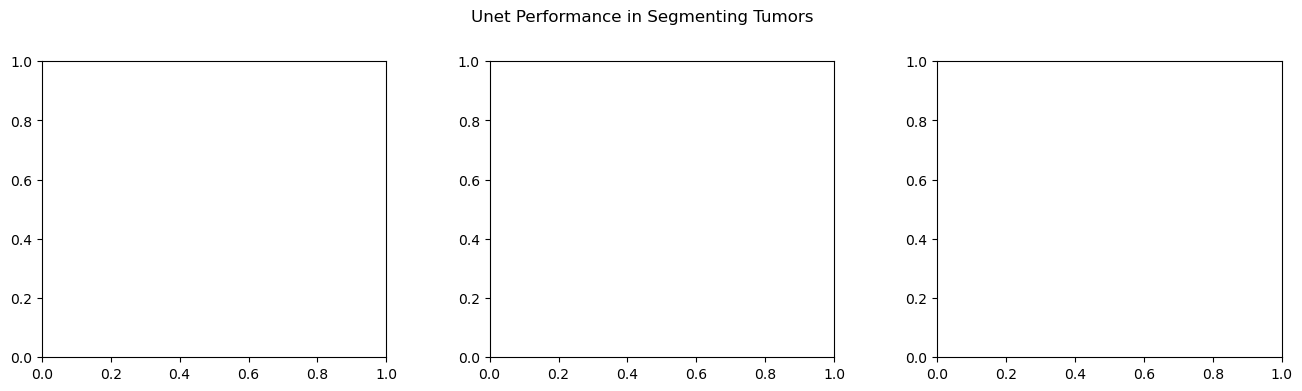

In [68]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
t = f.suptitle('Unet Performance in Segmenting Tumors', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = hist.epoch

ax1.plot(epoch_list, hist.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, hist.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('Accuracy Value');ax1.set_xlabel('Epoch');ax1.set_title('Accuracy')
ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax2.plot(epoch_list, hist.history['loss'], label='Train Loss')
ax2.plot(epoch_list, hist.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('Loss Value');ax2.set_xlabel('Epoch');ax2.set_title('Loss')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3.plot(epoch_list, hist.history['iou_metric'], label='Train IOU metric')
ax3.plot(epoch_list, hist.history['val_iou_metric'], label='Validation IOU metric')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('IOU metric');ax3.set_xlabel('Epoch');ax3.set_title('IOU metric')
ax3.legend(loc="best");ax3.grid(color='gray', linestyle='-', linewidth=0.5)

In [69]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def get_iou_vector(A, B):
    t = A>0
    p = B>0
    intersection = np.logical_and(t,p)
    union = np.logical_or(t,p)
    iou = (np.sum(intersection) + 1e-10 )/ (np.sum(union) + 1e-10)
    return iou
  
def getIOUCurve(mask_org,predicted):
  thresholds = np.linspace(0, 1, 100)
  ious = np.array([get_iou_vector(mask_org, predicted > threshold) for threshold in thresholds])
  thres_best_index = np.argmax(ious[9:-10]) + 9
  iou_best = ious[thres_best_index]
  thres_best = thresholds[thres_best_index]
  return thresholds,ious,iou_best,thres_best

20/20 ━━━━━━━━━━━━━━━━━━━━ 124s 6s/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 1231s 8s/step


Text(0.5, 1.0, 'Threshold vs IoU (0.4040404040404041, 0.792641526745573)')

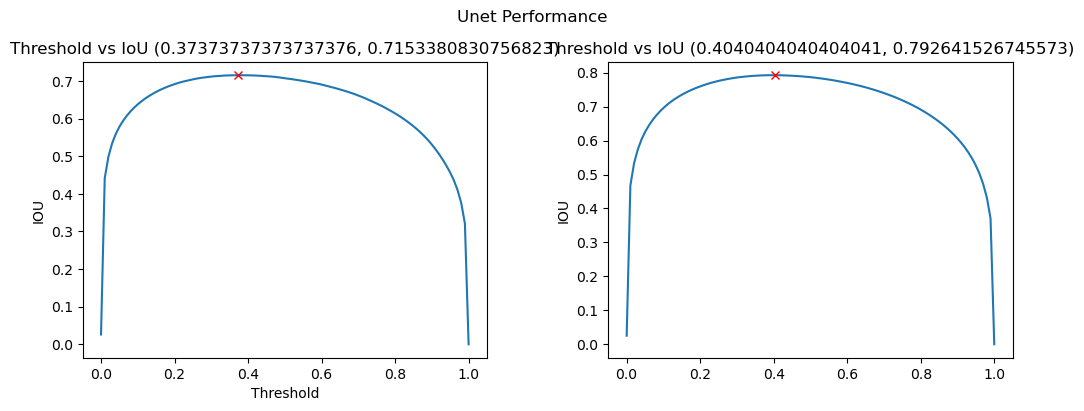

In [70]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Unet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

th, ious, iou_best, th_best = getIOUCurve(Y_v,unet.predict(X_v))
ax1.plot(th, ious,label="For Validation")
ax1.plot(th_best, iou_best, "xr", label="Best threshold")
ax1.set_ylabel('IOU');ax1.set_xlabel('Threshold')
ax1.set_title("Threshold vs IoU ({}, {})".format(th_best, iou_best))

th, ious, iou_best, th_best = getIOUCurve(Y,unet.predict(X))
ax2.plot(th, ious, label="For Training")
ax2.plot(th_best, iou_best, "xr", label="Best threshold")
ax2.set_ylabel('IOU');ax1.set_xlabel('Threshold')
ax2.set_title("Threshold vs IoU ({}, {})".format(th_best, iou_best))

20/20 ━━━━━━━━━━━━━━━━━━━━ 191s 10s/step


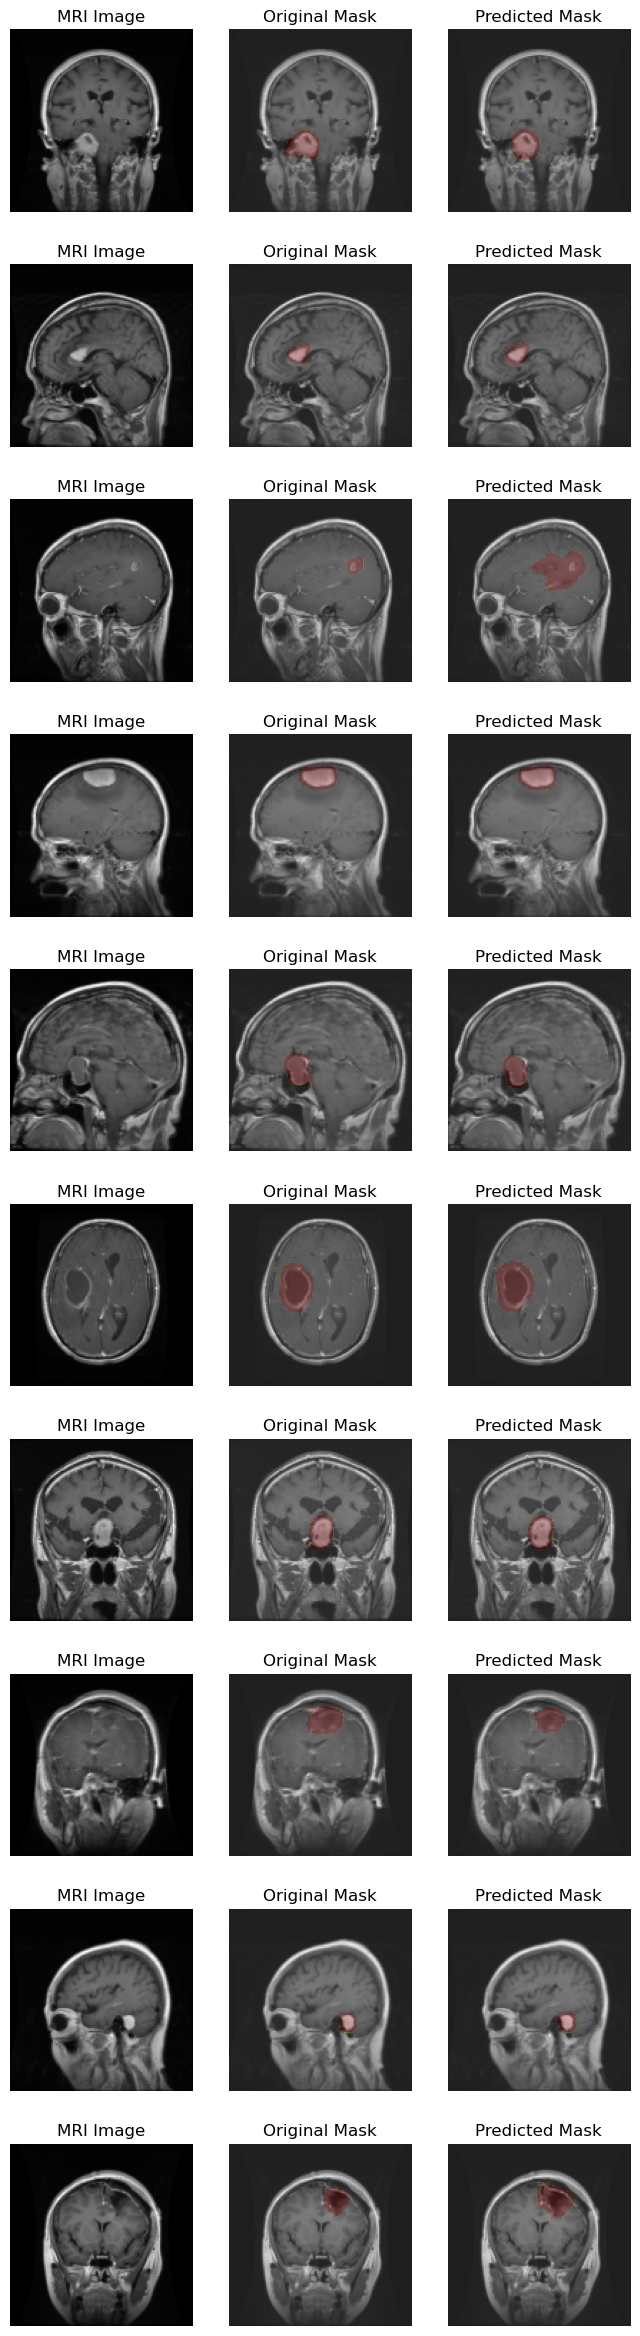

In [71]:
THRESHOLD = 0.2
predicted_mask = (unet.predict(X_v)>THRESHOLD)*1

plt.figure(figsize=(8,30))
i=1;total=10
temp = np.ones_like( Y_v[0] )
for idx in np.random.randint(0,high=X_v.shape[0],size=total):
    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(X_v[idx],axis=-1), cmap='gray' )
    plt.title("MRI Image");plt.axis('off')
    
    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(X_v[idx],axis=-1), cmap='gray' )
    plt.imshow( np.squeeze(temp - Y_v[idx],axis=-1), alpha=0.2, cmap='Set1' )
    plt.title("Original Mask");plt.axis('off')
    
    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(X_v[idx],axis=-1), cmap='gray' )
    plt.imshow( np.squeeze(temp - predicted_mask[idx],axis=-1),  alpha=0.2, cmap='Set1' )
    plt.title("Predicted Mask");plt.axis('off')

In [78]:
#advacning 
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from lovasz_losses_tf import lovasz_hinge
import albumentations as A

# Load the pretrained ResNet model without the top layer for transfer learning
base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the base model
base_model.trainable = False

# Define the U-Net model with the base_model as the encoder
def unet_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Use the base model for encoding
    encoder = base_model(inputs, training=False)
    
    # U-Net decoder
    c1 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(encoder)
    c1 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c1)
    u1 = layers.UpSampling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u1)
    c2 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c2)
    u2 = layers.UpSampling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    u3 = layers.UpSampling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    u4 = layers.UpSampling2D((2, 2))(c4)
    
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u4)
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c5)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)
    
    model = models.Model(inputs, outputs)
    
    return model

# Define augmented image generator
def create_augmented_gen(generator, augmenter, subset):
    for x, y in generator.flow_from_directory('data', subset=subset, target_size=(256, 256), class_mode='binary'):
        x_aug = np.stack([augmenter(image=image)['image'] for image in x], axis=0)
        yield x_aug, y

# Define the augmentations
augmenter = A.Compose([
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomZoom(p=0.2)
])

# Instantiate the model
model = unet_model((256, 256, 3))

# Compile the model with Lovasz loss
model.compile(optimizer='adam', loss=lovasz_hinge, metrics=['accuracy'])

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_gen = create_augmented_gen(train_datagen, augmenter, 'training')
val_gen = create_augmented_gen(train_datagen, augmenter, 'validation')

# Train the model
model.fit(train_gen, validation_data=val_gen, epochs=20, steps_per_epoch=100, validation_steps=10)

# Save the model
model.save('unet_brain_tumor_segmentation.h5')


ImportError: cannot import name '_average' from 'sklearn.utils._array_api' (/Users/EmilyHuang/anaconda3/lib/python3.11/site-packages/sklearn/utils/_array_api.py)